# <center>Fuzzy Clustering</center>
## <center>Inclass Project 1 - MA4144</center>

This project contains 9 tasks/questions to be completed, some require written answers. Open markdow cell below the respective question that require written answers and provide (type) your answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload this PDF on moodle**.

Use this cell to use any include any imports

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances,silhouette_score
from sklearn.datasets import make_blobs

**Q1.** In the following cell load the data (in the file SMDataRefined.csv) to a pandas dataframe, and display the data. Then get the data into a numpy matrix $X$, each row corresponding to a datapoint and each column to a feature, in our case whether a certain token exists ($1$) or not ($0$). Let us denote the number of rows of $X$ by $N$ and the number of columns by $M$.

**About the dataset**: Each row in the dataset refers to a social media post. The first column refers to the number of likes received by each post (standardized between to the interval $[0, 1]$), the columns after that will denote the presence of a certain word (token) in the text of the post. For example, a $1$ in the column "TextToken_life" denotes that the particular post contained the word "life" in it and $0$ otherwise. These will be the features of our dataset. Our aim is to cluster these social media posts based on number of likes and words contained in it.

In [15]:
df = pd.read_csv('SMDataRefined.csv')
print(df)

X = df.to_numpy()
N, M = X.shape

        Likes  TextToken_life  TextToken_joy  TextToken_night  \
0    0.285714               0              0                0   
1    0.000000               0              0                0   
2    0.428571               0              0                0   
3    0.071429               0              0                0   
4    0.214286               0              0                0   
..        ...             ...            ...              ...   
727  0.414286               0              0                0   
728  0.542857               0              0                0   
729  0.457143               0              1                0   
730  0.471429               0              0                0   
731  0.528571               0              0                0   

     TextToken_heart  TextToken_laughter  TextToken_dreams  TextToken_feeling  \
0                  0                   0                 0                  0   
1                  0                   0                 

**Q2.** In the following cell create a new function named $\textrm{initMu}$, that takes in two parameters $\textrm{npoints}$ and $\textrm{nclusters}$ and outputs the membership matrix for $\textrm{npoints}$ number of data points and $\textrm{nclusters}$ number of clusters. Recall from the lecture that the membership matrix $U$ of dimension $N \times c$ has the following properties.

1. $0 \leq u_{ij} \leq 1$
2. $\sum\limits_{j = 1}^{c}u_{ij} = 1$ for all $i = 1,2, \cdots, N$

You can do a random initialization. Here $\textrm{npoints} = N$ and $\textrm{nclusters} = c$.

In [8]:
def initMu(npoints, nclusters):
    U = np.random.rand(npoints, nclusters)
    U /= U.sum(axis=1, keepdims=True)
    return U

**Q3.** In the following cell create a function named $\textrm{calculateCenters}$ that computes and returns centers $v_j$, $j = 1, 2, \cdots, c$ (as $c \times M$ matrix) given the data matrix $X$ and the membership matrix $U$. Recall the following update formula for $v_j$ from the lectures.

$v_j = \frac{\sum\limits_{i = 1}^N {\left( \frac{u_{ij}}{u_{max}} \right)}^{m_1} x_i}{\sum\limits_{i = 1}^N {\left( \frac{u_{ij}}{u_{max}} \right)}^{m_1}}$

Here $u_{max} = max \left(u_{1j}, u_{2j}, \cdots, u_{Nj} \right)$ and $m_1 \in [1, \infty)$ is a hyperparameter we discussed in class, and will be passed in as a parameter to the function.

The most efficient way to do this computation is by matrix multiplications. Try to find the appropriate matrix multiplication. You may need to transpose certain matrices.

In [16]:
def calculateCenters(X, U, m):
    u_max = np.max(U, axis=0)

    weighted_values = (U * u_max) ** m
    numerator = np.dot(weighted_values.T, X)
    denominator = np.sum(weighted_values, axis=0).reshape(-1, 1)
    
    return numerator/denominator

**Q4.** In the following cell create a function named $\textrm{updateMu}$ that updates the membership matrix $U$ given the data matrix $X$ and the $\textrm{centers}$. Recall the following update formula for $u_{ij}$ from the lectures.

$u_{ij} = {\left[ \sum\limits_{l = 1}^c { \left( \frac{d_{ij}}{d_{il}} \right)}^{\frac{2}{m_2 - 1}} \right]}^{-1}$
where $d_{ij}$ is the distance between the $i$th data point and the $j$th cluster center. $m_2 \in (1, \infty)$ is another hyperparameter that is passed into the function.

To compute distances sklearn.metrics.pairwise.pairwise_distances could be useful. For these computations, try to avoid for loops as much as possible and use the tools offered by numpy for matrix manipulations for example such as numpy.tile.

The function should finally return the updated $U$ matrix.

In [17]:
def updateMu(X, centers, m):
    distances = pairwise_distances(X, centers)
    permissible_minimum = 1e-10
    
    distances = np.maximum(distances, permissible_minimum)
    exponent = 2 / (m - 1)
    
    inv_distances = distances ** (-exponent)
    
    dist_ratio = distances[:, :, np.newaxis] / distances[:, np.newaxis, :]
    sum_ratios = np.sum(dist_ratio ** exponent, axis=2)
    
    U = sum_ratios ** (-1)
    U /= U.sum(axis=1, keepdims=True)
    return U

**Q5.** Use following cell to create a function called $\textrm{fuzzyClustering}$ that takes in a data matrix $X$ the number of clusters $\textrm{nclusters}$, $m_1$, $m_2$ hyperparameters and then returns a membership matrix $U$ and nclusters number of centers for each cluster as a matrix whose rows will correspond to the centers. Recall that the fuzzy clustering algorithm,

1. Initialize the membership matrix $U$
Repeat the following steps while max iterations (maxIter) reached or change in norm of $U$ is greater than a specified tolerance (tol).
2. Compute cluster centers
3. Update membership matrix

The function you create should be able to compute the norm between the $U$ matrices from consecutive iterations and plot a graph depicting the variation of the change in norm of $U$ against the number of iterations. 

In [20]:
def fuzzyClustering(X, m1, m2, nclusters, maxiter = 50, tol = 10**(-5),plot=True):
    npoints,nfeatures=X.shape
    
    U = initMu(npoints, nclusters)


    norms,interation=[],0

    for iteration in range(maxiter):
        U_prev=U.copy()

        centers = calculateCenters(X, U, m1)
        U = updateMu(X, centers, m2)

        norm = np.linalg.norm(U - U_prev)
        norms.append(norm)


        if norm < tol:
            break

    if plot:
        plt.plot(norms)
        plt.xlabel('Iteration Number')
        plt.ylabel('Norm of Membership Matrix Change')
        plt.title('Convergence of Membership Matrix Norm Over Iterations')
        plt.grid(True)
        plt.show()

    return U, centers


**Q6.** Run the fuzzyClasssification algorithm with different hyperparameters $m_1, m_2, \textrm{nclusters}$, note the plot of $U$-norm difference against the number of iterations. <font color='blue'>What can you say about it?</font>

Now lets use the fuzzy membership to find some crisp cluster labelling $\textrm{yfuzzy}$ to for each data point. For a given datapoint you'll assign the cluster labelling by looking at which cluster assigns the largest membership value. numpy.argmax function would be useful in this case. Again avoid for loops. 

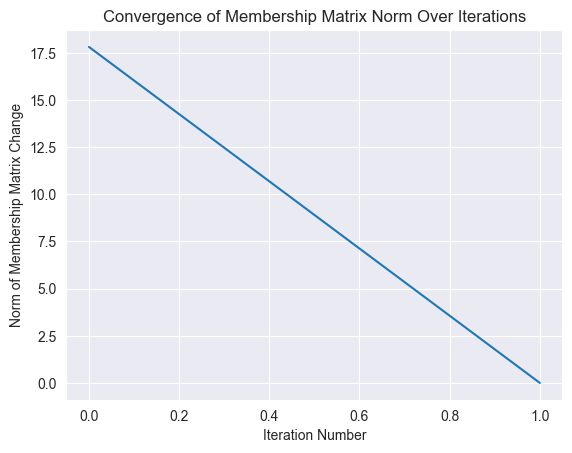

[7 8 1 8 2 7 8 2 9 1 2 8 8 2 8 1 8 1 5 8 5 8 7 1 8 8 2 8 5 8 1 8 2 5 7 5 1
 8 2 9 5 8 7 1 8 8 9 8 1 8 2 1 1 8 5 1 9 5 8 7 5 1 8 5 1 7 8 5 1 1 7 5 5 1
 9 8 1 7 5 1 2 5 7 1 5 1 8 7 1 7 8 5 1 1 7 5 5 7 9 8 5 1 8 8 9 2 5 8 8 1 8
 5 1 9 5 8 1 5 1 2 5 1 5 8 9 5 8 2 5 1 5 1 8 5 1 5 1 8 5 1 9 2 8 1 5 1 2 5
 1 5 8 9 5 7 1 2 1 5 1 8 5 1 5 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 7 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 7 8 8 1 8 8 8 7 8 8 8 7 5 2 8 8 8 7 8
 8 1 1 5 8 8 8 8 8 8 1 1 7 5 7 8 8 8 8 8 1 7 7 5 8 7 7 7 5 7 8 1 7 1 2 8 5
 7 1 8 1 7 5 5 8 7 7 1 1 7 7 7 8 7 8 7 5 5 8 7 7 1 1 7 7 7 8 7 8 7 5 5 8 7
 8 8 8 8 7 8 5 1 7 8 1 8 7 7 8 8 1 7 7 7 1 8 8 8 1 8 7 8 5 1 7 8 1 8 7 7 9
 8 5 9 1 5 9 9 1 1 5 1 9 9 5 9 8 7 1 9 5 1 5 9 9 1 9 8 7 2 1 5 9 1 9 7 9 1
 7 1 7 9 7 9 1 1 5 9 8 7 9 1 9 9 7 9 1 1 5 1 7 9 7 9 1 1 5 9 8 7 9 1 9 9 7
 9 1 1 1 5 9 9 1 5 7 1 5 9 8 1 7 9 7 7 9 1 9 9 7 5 9 1 7 9 1 9 5 7 1 5 7 5
 8 7 7 9 5 9 7 1 7 7 7 5 8 5 1 9 9 1 5 5 1 7 1 7 8 9 9 9 7 7 7 9 1 7 5 9 9
 7 9 5 5 9 1 7 7 9 7 9 5 

In [21]:
m1=2
m2=2
nclusters=11
U,centers= fuzzyClustering(X,m1,m2,nclusters)
crisp_labels = np.argmax(U, axis=1)
print(crisp_labels)

**Q7.** The Silhoutte score is a measure of how well the clustering has been done, the closer the score to $1.0$ the better the clustering. Refer to sklearn.metrics.silhouette_score. Determine the best choice of hyperparameters $m_1, m_2, \textrm{nclusters}$ through a grid search based on the silhoutte score as the evaluation metric. <font color='blue'>Report the best combination of hyperparameters.</font> For the grid search try $m_1 = 1.0, 1.2, \cdots, 3.0$, $m_2 = 1.2, 1.4, \cdots, 3.0$, $\textrm{nclusters} = 2, 3, \cdots, 15$.

In [ ]:
#TODO fill in the code

**Q8.** For the best combination of hyperparameters run the following visualization function with different values for $0 \leq f_1 < f_2 < \textrm{nclusters}$. <font color='blue'>What do you see? Explain the purpose of the code and what you would expect through this?</font>

In [8]:
def visualizeClusters2D(X, y, f1, f2):
    colorlist = ['black', 'gray', 'red', 'sienna', 'green', 'blue', 'gold', 'darkorange', 'olive', 'lavendar', 'salmon', 'teal', 'pink', 'magenta', 'tan', 'wheat']

    for i in range(8):
        plt.scatter(X[yfuzzy == i, f1], X[yfuzzy == i, f2], color = colorlist[i])

    plt.show()


In [ ]:
#TODO fill in the code

**Q9.** Load (to a pandas dataframe) the actual dataset (SMData.csv) from which the previous dataset was cleaned out. Match each entry in this dataset with the labels you found out through clustering using the best combination of hyperparameters. Go through a few of those clustered entries and notice any patterns (or common sentiment) in the text (the "Text" column of this dataset) of each entry within clusters vs outside the clusters. The label of the $i$th entry in the dataset $= \textrm{yfuzzy}[i]$. <font color='blue'>Explain any observations. Based on your observations, is the clustering successful?</font>

In [ ]:
#TODO fill in the code